# Goal 1 - What sort of stories become prominent on Medium?
We will perform a multivariate regression of views onto multiple independent variables like word count, reading time, total clap count, and others.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
import string
import re
%matplotlib inline

/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("Medium_AggregatedData.csv")

In [3]:
len(df)

279577

In [4]:
df = df[df['totalClapCount'] != 0]

In [5]:
len(df)

198864

In [6]:
df.drop(columns=['audioVersionDurationSec', 'codeBlock', 'codeBlockCount', 'collectionId', 'createdDate', 
                 'createdDatetime', 'firstPublishedDate','firstPublishedDatetime','imageCount', 'isSubscriptionLocked',
                 'latestPublishedDate', 'latestPublishedDatetime', 'linksCount', 'responsesCreatedCount', 
                 'socialRecommendsCount','uniqueSlug', 'updatedDate', 'updatedDatetime', 'url', 'vote',
                 'publicationdomain','publicationfacebookPageName', 'publicationdescription',
                 'publicationfollowerCount','publicationname', 'publicationpublicEmail', 'publicationslug',
                 'publicationtags', 'publicationtwitterUsername','slug','name', 'postCount',
                 'usersFollowedByCount', 'usersFollowedCount', 'scrappedDate'], inplace=True)

In [7]:
df.isnull().any()

language          False
postId            False
readingTime       False
recommends        False
subTitle           True
tagsCount         False
text              False
title              True
totalClapCount    False
wordCount         False
tag_name          False
author            False
bio                True
userId            False
userName          False
dtype: bool

In [8]:
df = df.dropna(axis=0, subset=['subTitle', 'title', 'bio'])

In [9]:
len(df)

163454

In [10]:
df = df[:5000]

In [11]:
df['title_len'] = df['title'].str.len()
df['text_len'] = df['text'].str.len()

In [12]:
df['title'] = df['title'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: x.lower())
df['author'] = df['author'].apply(lambda x: x.lower())

In [13]:
df['title_clean'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [14]:
df['text_clean'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

In [15]:
df['title_clean'] = df['title'].apply(lambda x: re.sub('[' + string.punctuation + '—]', '', x))
df['text_clean'] = df['text'].apply(lambda x: re.sub('[' + string.punctuation + '—]', '', x))

df['title_clean'] = df['title_clean'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))
df['text_clean'] = df['text_clean'].apply(lambda x: x.translate(str.maketrans('', '', string.digits)))

df['title_clean'] = df['title_clean'].apply(lambda x: re.sub(' +', ' ', x))
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(' +', ' ', x))

df['title_clean_len'] = df['title_clean'].str.len()
df['text_clean_len'] = df['text_clean'].str.len()

df['full_text'] = df['author'] + ' ' + df['title_clean'] + ' ' + df['text_clean']

In [16]:
vectorizer = TfidfVectorizer(max_features=None)
full_text_features = vectorizer.fit_transform(df['full_text'])

In [17]:
scaler = StandardScaler()
num_features = scaler.fit_transform(df[['readingTime', 'title_len', 'text_len', 'title_clean_len', 'text_clean_len']])

In [18]:
full_text_features = np.concatenate([full_text_features.toarray(), num_features], axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(full_text_features, df[['totalClapCount']].values, test_size=0.3)

# Linear Regression

In [20]:
reg = LinearRegression().fit(X_train, y_train)

In [21]:
y_pred = reg.predict(X_test)
y_pred.shape

(1500, 1)

In [22]:
r2_score(y_test, y_pred)

0.9748324664004425

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

7832.7009840837745

Text(0.5,1,'Linear Regression Model')

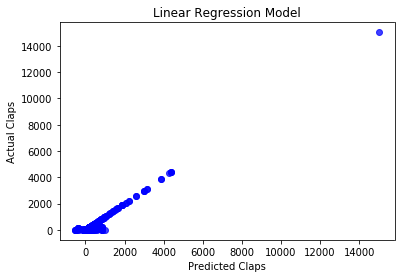

In [24]:
actual_values = y_test
plt.scatter(y_pred, actual_values, alpha=.75, color='b')
plt.xlabel('Predicted Claps')
plt.ylabel('Actual Claps')
plt.title('Linear Regression Model')

# Random Forest Regressor

In [25]:
from sklearn import ensemble
lr2 = ensemble.RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,
                                     random_state =20, max_features = "sqrt", min_samples_leaf = 30)

In [26]:
modelRF = lr2.fit(X_train, y_train)

/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [27]:
print ("R^2 is: \n", modelRF.score(X_test, y_test))

R^2 is: 
 0.1346692374573094


In [28]:
RFRpredictions = modelRF.predict(X_test)

In [29]:
print ('RMSE is: \n', mean_squared_error(y_test, RFRpredictions))

RMSE is: 
 269310.3433641691


Text(0.5,1,'Random Forest Regression Model')

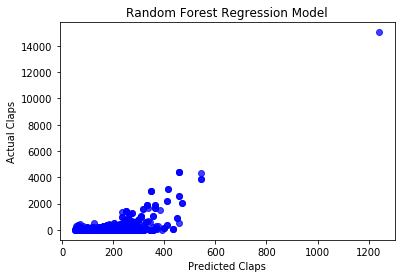

In [30]:
actual_values = y_test
plt.scatter(RFRpredictions, actual_values, alpha=.75, color='b')
plt.xlabel('Predicted Claps')
plt.ylabel('Actual Claps')
plt.title('Random Forest Regression Model')

# Gradient Boosting Regressor

In [31]:
lr = ensemble.GradientBoostingRegressor()

In [32]:
modelGR = lr.fit(X_train, y_train)

/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
print ("R^2 is: \n", modelGR.score(X_test, y_test))

R^2 is: 
 0.9307193078315582


In [41]:
GBRpredictions = modelGR.predict(X_test)

In [42]:
print ('RMSE is: \n', mean_squared_error(y_test, GBRpredictions))

RMSE is: 
 21561.705424138192


Text(0.5,1,'Gradient Boosting Regression Model')

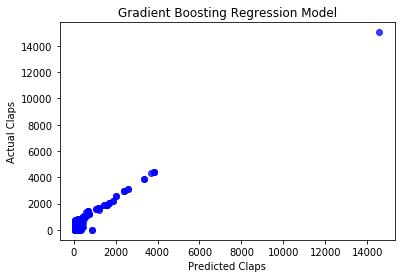

In [43]:
actual_values = y_test
plt.scatter(GBRpredictions, actual_values, alpha=.75, color='b')
plt.xlabel('Predicted Claps')
plt.ylabel('Actual Claps')
plt.title('Gradient Boosting Regression Model')

# Support Vector Regression

In [44]:
from sklearn.svm import SVR

In [45]:
clf = SVR()

In [46]:
modelsvr = clf.fit(X_train, y_train)

/opt/ohpc/pub/apps/python3/3.7.0/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
print ("R^2 is: \n", modelsvr.score(X_test, y_test))

R^2 is: 
 -0.04427851047669429


In [48]:
svrpredictions = modelsvr.predict(X_test)

Text(0.5,1,'SVR Regression Model')

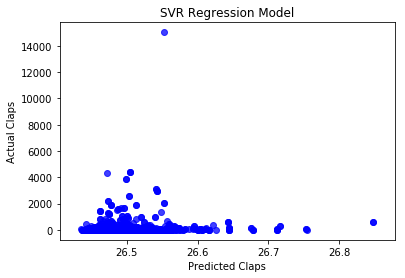

In [49]:
actual_values = y_test
plt.scatter(svrpredictions, actual_values, alpha=.75, color='b')
plt.xlabel('Predicted Claps')
plt.ylabel('Actual Claps')
plt.title('SVR Regression Model')

In [50]:
print ('RMSE is: \n', mean_squared_error(y_test, svrpredictions))

RMSE is: 
 325002.8964622959


In [61]:
svrpredictions

array([26.52617903, 26.542656  , 26.48358103, ..., 26.49007638,
       26.50235792, 26.48061311])

In [62]:
GBRpredictions

array([  83.71251138, 2396.13480737,   68.54489008, ...,   89.73964034,
        211.3785125 ,   72.92775058])

In [63]:
RFRpredictions

array([185.18178901, 348.26424855, 184.77967622, ..., 135.22627492,
       211.9215026 , 248.42922438])

In [67]:
linPredictions = y_pred

In [68]:
linPredictions

array([[1.900e+01],
       [2.972e+03],
       [1.500e+01],
       ...,
       [1.000e+00],
       [1.630e+02],
       [1.500e+01]])